In [1]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import cv2
import PIL.Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from util import GradualWarmupSchedulerV2
#import apex
#from apex import amp
from dataset import get_df, get_transforms, MelanomaDataset
from models import Effnet_Melanoma, Resnest_Melanoma, Seresnext_Melanoma
from train import get_trans


from evaluate import val_epoch

In [2]:
''' 
python train.py 
--kernel-type 9c_meta_b3_768_512_ext_18ep 
--data-dir ./data/ 
--data-folder 768 
--image-size 512 
--enet-type efficientnet_b3 
--n-epochs 18 
--CUDA_VISIBLE_DEVICES 0

    parser.add_argument('--kernel-type', type=str, required=True)
    parser.add_argument('--data-dir', type=str, default='/raid/')
    parser.add_argument('--data-folder', type=int, required=True)
    parser.add_argument('--image-size', type=int, required=True)
    parser.add_argument('--enet-type', type=str, required=True)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument('--num-workers', type=int, default=32)
    parser.add_argument('--out-dim', type=int, default=9)
    parser.add_argument('--use-amp', action='store_true')
    parser.add_argument('--use-meta', action='store_true')
    parser.add_argument('--DEBUG', action='store_true')
    parser.add_argument('--model-dir', type=str, default='./weights')
    parser.add_argument('--log-dir', type=str, default='./logs')
    parser.add_argument('--oof-dir', type=str, default='./oofs')
    parser.add_argument('--eval', type=str, choices=['best', 'best_20', 'final'], default="best")
    parser.add_argument('--CUDA_VISIBLE_DEVICES', type=str, default='0')
    parser.add_argument('--n-meta-dim', type=str, default='512,128')
'''

kernel_type = '9c_meta_b3_768_512_ext_18ep'
out_dim = 9
data_dir = './data/'
data_folder = 768
image_size = 512
enet_type = 'efficientnet_b3'
n_epochs = 18
batch_size = 64
num_workers = 1
init_lr = 3e-5
use_amp = False
use_meta = False
DEBUG = False
model_dir = './weights'
log_dir = './logs'
oof_dir = './oofs'
n_meta_dim='512,128'

os.makedirs(oof_dir, exist_ok=True)

eval_model = 'final'

if enet_type == 'resnest101':
    ModelClass = Resnest_Melanoma
elif enet_type == 'seresnext101':
    ModelClass = Seresnext_Melanoma
elif 'efficientnet' in enet_type:
    ModelClass = Effnet_Melanoma
else:
    raise NotImplementedError()

device = torch.device('cuda')

In [3]:
df, df_test, meta_features, n_meta_features, mel_idx = get_df(
    kernel_type,
    out_dim,
    data_dir,
    data_folder,
    use_meta
)

df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,filepath,fold,is_ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,8,0,6000,4000,./data/jpeg-melanoma-768x768/train/ISIC_263701...,2,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,8,0,6000,4000,./data/jpeg-melanoma-768x768/train/ISIC_001571...,2,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,7,6,1872,1053,./data/jpeg-melanoma-768x768/train/ISIC_005221...,4,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,8,0,1872,1053,./data/jpeg-melanoma-768x768/train/ISIC_006827...,2,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,8,11,6000,4000,./data/jpeg-melanoma-768x768/train/ISIC_007426...,3,0


In [4]:
transforms_train, transforms_val = get_transforms(image_size)
transforms_val


Compose([
  Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [5]:
fold = 0
if eval_model == 'best':
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')
elif eval_model == 'best_20':
    model_file = os.path.join(model_dir, f'{kernel_type}_best_20_fold{fold}.pth')
if eval_model == 'final':
    model_file = os.path.join(model_dir, f'{kernel_type}_final_fold{fold}.pth')

model = ModelClass(
    enet_type,
    n_meta_features=n_meta_features,
    n_meta_dim=[int(nd) for nd in n_meta_dim.split(',')],
    out_dim=out_dim
)
model = model.to(device)

try:
    model.load_state_dict(torch.load(model_file), strict=True)
except:  
    raise Exception('No single GPU model_file')

model.eval()

Effnet_Melanoma(
  (enet): GenEfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [6]:
#LOGITS = []
#PROBS = []
#dfs = []
#for fold in range(1):
#
#    df_valid = df[df['fold'] == fold]
#    if DEBUG:
#        df_valid = pd.concat([
#            df_valid[df_valid['target'] == mel_idx].sample(batch_size * 3),
#            df_valid[df_valid['target'] != mel_idx].sample(batch_size * 3)
#        ])
#
#    dataset_valid = MelanomaDataset(df_valid, 'valid', meta_features, transform=transforms_val)
#    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=num_workers)
#
#    if eval_model == 'best':
#        model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')
#    elif eval_model == 'best_20':
#        model_file = os.path.join(model_dir, f'{kernel_type}_best_20_fold{fold}.pth')
#    if eval_model == 'final':
#        model_file = os.path.join(model_dir, f'{kernel_type}_final_fold{fold}.pth')
#
#    model = ModelClass(
#        enet_type,
#        n_meta_features=n_meta_features,
#        n_meta_dim=[int(nd) for nd in n_meta_dim.split(',')],
#        out_dim=out_dim
#    )
#    model = model.to(device)
#
#    try:
#        model.load_state_dict(torch.load(model_file), strict=True)
#    except:  
#        Exception('No single GPU model_file')
#    
#    model.eval()
#
#    this_LOGITS, this_PROBS = val_epoch(device, model, valid_loader, mel_idx, 
#                                        is_ext=df_valid['is_ext'].values, n_test=8, 
#                                        get_output=True, out_dim=out_dim)
#    LOGITS.append(this_LOGITS)
#    PROBS.append(this_PROBS)
#    dfs.append(df_valid)
#
#

In [7]:
#dfs = pd.concat(dfs).reset_index(drop=True)
#dfs['pred'] = np.concatenate(PROBS).squeeze()[:, mel_idx]
#
#auc_all_raw = roc_auc_score(dfs['target'] == mel_idx, dfs['pred'])
#
#dfs2 = dfs.copy()
#for i in range(5):
#    dfs2.loc[dfs2['fold'] == i, 'pred'] = dfs2.loc[dfs2['fold'] == i, 'pred'].rank(pct=True)
#auc_all_rank = roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])
#
#dfs3 = dfs[dfs.is_ext == 0].copy().reset_index(drop=True)
#auc_20_raw = roc_auc_score(dfs3['target'] == mel_idx, dfs3['pred'])
#
#for i in range(5):
#    dfs3.loc[dfs3['fold'] == i, 'pred'] = dfs3.loc[dfs3['fold'] == i, 'pred'].rank(pct=True)
#auc_20_rank = roc_auc_score(dfs3['target'] == mel_idx, dfs3['pred'])
#
#content = f'Eval {eval_model}:\nauc_all_raw : {auc_all_raw:.5f}\nauc_all_rank : {auc_all_rank:.5f}\nauc_20_raw : {auc_20_raw:.5f}\nauc_20_rank : {auc_20_rank:.5f}\n'
#print(content)
#with open(os.path.join(log_dir, f'log_{kernel_type}.txt'), 'a') as appender:
#    appender.write(content + '\n')
#
#np.save(os.path.join(oof_dir, f'{kernel_type}_{eval_model}_oof.npy'), dfs['pred'].values)

In [8]:
#dfs.head()

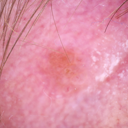

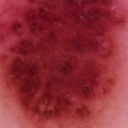

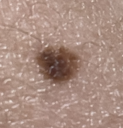

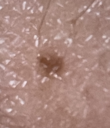

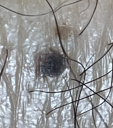

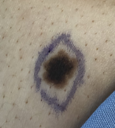

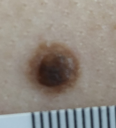

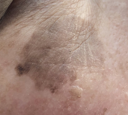

In [9]:
from PIL import Image

files = [
    './data/jpeg-melanoma-768x768/train/ISIC_2637011.jpg',
    './data/jpeg-melanoma-768x768/train/ISIC_9999806.jpg',
    './data/brian/IMG_3239.jpg',
    './data/brian/IMG_3240.jpg',
    './data/brian/IMG_3241.jpg',
    './data/brian/IMG_4510.jpg',
    './data/brian/IMG_4660.jpg',
    './data/brian/IMG_4662.jpg',
]

for f in files:
    img = Image.open(f)
    img.thumbnail((128, 128))
    img.show()

In [10]:
import albumentations 
import cv2

def prepare_data(image_path, image_size):
    transform_fn = albumentations.Compose([
        #albumentations.CenterCrop(image_size, image_size),
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize(),
    ])
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #res = transform_fn(image=image)
    res = transforms_val(image=image)
    image = res['image'].astype(np.float32)
    image = image.transpose(2, 0, 1)

    return torch.tensor(image).float()

data = prepare_data(files[3], image_size=image_size)
print(data.shape)
data

torch.Size([3, 512, 512])


tensor([[[ 1.3242,  1.2899,  1.2557,  ...,  0.5364,  0.5707,  0.5878],
         [ 1.2385,  1.2557,  1.2385,  ...,  0.5707,  0.5878,  0.5707],
         [ 1.1872,  1.1872,  1.1700,  ...,  0.5878,  0.5707,  0.5193],
         ...,
         [ 0.5022,  0.5364,  0.5878,  ...,  0.5536,  0.5707,  0.5536],
         [ 0.4851,  0.5364,  0.6049,  ...,  0.5193,  0.5364,  0.5193],
         [ 0.5022,  0.5364,  0.5878,  ...,  0.5022,  0.4851,  0.4508]],

        [[ 0.9930,  0.9580,  0.9230,  ...,  0.1527,  0.1877,  0.2052],
         [ 0.9230,  0.9405,  0.9055,  ...,  0.1877,  0.2052,  0.1877],
         [ 0.8704,  0.8880,  0.8529,  ...,  0.2052,  0.1877,  0.1352],
         ...,
         [ 0.0301,  0.0651,  0.1176,  ...,  0.0476,  0.0651,  0.0476],
         [ 0.0126,  0.0651,  0.1352,  ...,  0.0126,  0.0301,  0.0301],
         [ 0.0126,  0.0651,  0.1527,  ..., -0.0049, -0.0224, -0.0049]],

        [[ 1.1411,  1.1062,  1.0714,  ...,  0.2348,  0.2696,  0.2871],
         [ 1.0191,  1.0539,  1.0191,  ...,  0

In [11]:
from train import get_trans

def predict(data, device, n_test=8, out_dim=9):
    labels = ['AK', 'BCC', 'BKL', 'DF', 'SCC', 'VASC', 'melanoma', 'nevus', 'unknown']
    #model.eval()
    data = data.to(device).unsqueeze(0)
    data = data.to(device)

    logits = torch.zeros((data.shape[0], out_dim)).to(device)
    probs = torch.zeros((data.shape[0], out_dim)).to(device)

    for I in range(n_test):
        l = model(get_trans(data, I))
        logits += l
        probs += l.softmax(1)

    logits /= n_test
    probs /= n_test

    del data
    logits = np.squeeze(logits.detach().cpu())
    probs = np.squeeze(probs.detach().cpu())
    labels = pd.Series(probs, index=labels)
    return logits, probs, labels



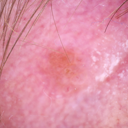

AK          2.030909e-06
BCC         1.847738e-07
BKL         1.489637e-04
DF          9.760914e-09
SCC         1.558907e-06
VASC        4.026991e-08
melanoma    3.196901e-06
nevus       3.997349e-04
unknown     9.994442e-01
dtype: float32


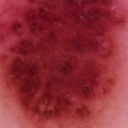

AK          7.619803e-08
BCC         4.235759e-08
BKL         4.893917e-07
DF          4.355451e-07
SCC         3.494309e-09
VASC        7.465878e-07
melanoma    6.877759e-05
nevus       9.902920e-01
unknown     9.637387e-03
dtype: float32


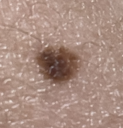

AK          1.241828e-06
BCC         1.346660e-05
BKL         6.779860e-03
DF          5.646487e-07
SCC         2.725857e-07
VASC        1.076120e-06
melanoma    5.247490e-04
nevus       9.739574e-01
unknown     1.872129e-02
dtype: float32


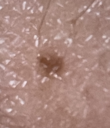

AK          0.000628
BCC         0.004591
BKL         0.032569
DF          0.000012
SCC         0.000064
VASC        0.000008
melanoma    0.001008
nevus       0.725721
unknown     0.235400
dtype: float32


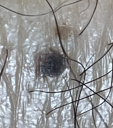

AK          0.000048
BCC         0.001562
BKL         0.066594
DF          0.000006
SCC         0.000003
VASC        0.000010
melanoma    0.000561
nevus       0.907124
unknown     0.024091
dtype: float32


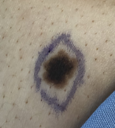

AK          8.108557e-11
BCC         2.103708e-08
BKL         2.202826e-06
DF          1.225232e-09
SCC         9.350816e-11
VASC        1.786988e-08
melanoma    7.889606e-05
nevus       8.626405e-01
unknown     1.372784e-01
dtype: float32


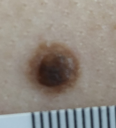

AK          0.000007
BCC         0.000055
BKL         0.001007
DF          0.000013
SCC         0.000001
VASC        0.000011
melanoma    0.000199
nevus       0.998695
unknown     0.000010
dtype: float32


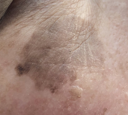

AK          4.755687e-06
BCC         1.165814e-03
BKL         3.648379e-03
DF          3.128102e-08
SCC         6.133570e-08
VASC        5.074128e-07
melanoma    7.435276e-03
nevus       5.587979e-02
unknown     9.318654e-01
dtype: float32


In [12]:
for f in files:
    data = prepare_data(f, image_size=image_size)
    logits, probs, labels = predict(data, device)

    img = Image.open(f)
    img.thumbnail((128, 128))
    img.show()
    print(labels)